# Zarr ds

In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

## Open SOSE Dataset from the Cloud

In [4]:
ds = xr.open_zarr(gcsfs.GCSMap('pangeo-data/SOSE'), consolidated=True)
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 d

In [5]:
print('Total Size: %6.2F GB' % (ds.nbytes / 1e9))

Total Size: 1408.75 GB


A trick for optimization: split the dataset into coordinates and data variables, and then drop the coordinates from the data variables.
This makes it easier to align the data variables in arithmetic operations.

In [6]:
coords = ds.coords.to_dataset().reset_coords()
dsr = ds.reset_coords(drop=True)
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 4

In [8]:
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
Data variables:
    drF      (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    hFacC    (Z, YC, XC) float32 dask.array<chunksize=(42, 320, 2160), meta=np.ndarray>
    rAw      (YC, 

## Create xgcm grid

[Xgcm](http://xgcm.readthedocs.io) is a package which helps with the analysis of GCM data.

In [9]:
import xgcm
grid = xgcm.Grid(ds, periodic=('X', 'Y'))
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (periodic):
  * center   XC --> left
  * left     XG --> center
T Axis (not periodic):
  * center   time
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center

## Tracer Budgets

Here we will do the heat and salt budgets for SOSE. In integral form, these budgets can be written as

$$
\mathcal{V} \frac{\partial S}{\partial t} = G^S_{adv} + G^S_{diff} + G^S_{surf} + G^S_{linfs}
$$


$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

In [27]:
def tracer_flux_budget(suffix):
    """Calculate the convergence of fluxes of tracer `suffix` where 
    `suffix` is `TH` or `SLT`. Return a new xarray.Dataset."""
    conv_horiz_adv_flux = -(grid.diff(dsr['ADVx_' + suffix], 'X') +
                          grid.diff(dsr['ADVy_' + suffix], 'Y')).rename('conv_horiz_adv_flux_' + suffix)
    conv_horiz_diff_flux = -(grid.diff(dsr['DFxE_' + suffix], 'X') +
                          grid.diff(dsr['DFyE_' + suffix], 'Y')).rename('conv_horiz_diff_flux_' + suffix)
    # sign convention is opposite for vertical fluxes
    conv_vert_adv_flux = grid.diff(dsr['ADVr_' + suffix], 'Z', boundary='fill').rename('conv_vert_adv_flux_' + suffix)
    conv_vert_diff_flux = (grid.diff(dsr['DFrE_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['DFrI_' + suffix], 'Z', boundary='fill') +
                           grid.diff(dsr['KPPg_' + suffix], 'Z', boundary='fill')).rename('conv_vert_diff_flux_' + suffix)
    
    all_fluxes = [conv_horiz_adv_flux, conv_horiz_diff_flux, conv_vert_adv_flux, conv_vert_diff_flux]
    #conv_all_fluxes = sum(all_fluxes).rename('conv_total_flux_' + suffix)
    #return xr.merge(all_fluxes + [conv_all_fluxes])
    return xr.merge(all_fluxes)

In [28]:
# sum of all converging adv/diff fluxes
budget_slt = tracer_flux_budget('SLT')
budget_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>

In [29]:
budget_slt.conv_horiz_adv_flux_SLT.data

,Array,Chunk
Bytes,50.86 GB,115.71 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 319, 2159)"
Count,23654 Tasks,1752 Chunks
Type,float32,numpy.ndarray


In [30]:
budget_th = tracer_flux_budget('TH')
budget_th

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>

In [31]:
budget_slt.conv_horiz_adv_flux_SLT.data

,Array,Chunk
Bytes,50.86 GB,115.71 MB
Shape,"(438, 42, 320, 2160)","(1, 42, 319, 2159)"
Count,23654 Tasks,1752 Chunks
Type,float32,numpy.ndarray


In [32]:
#adding true total tendency

volume = (coords.drF * coords.rA * coords.hFacC)
#client.scatter(volume)
day2seconds = (24*60*60)

budget_th['total_tendency_TH_truth'] = (dsr.TOTTTEND * volume) / day2seconds
budget_slt['total_tendency_SLT_truth'] = (dsr.TOTSTEND * volume) / day2seconds

In [33]:
budget_th

<xarray.Dataset>
Dimensions:                  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                     (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                        (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                       (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                       (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_TH  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_TH    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_TH   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_TH_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

In [34]:
budget_slt

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

### Surface Fluxes

The surface fluxes are only active in the top model layer. We need to specify some constants to convert to the proper units and scale factors to convert to integral form. They also require some xarray special sauce to merge with the 3D variables.

In [35]:
# constants
heat_capacity_cp = 3.994e3
runit2mass = 1.035e3 #rho

# treat the shortwave flux separately from the rest of the surface flux
surf_flux_th = (dsr.TFLUX - dsr.oceQsw) * coords.rA / (heat_capacity_cp * runit2mass)
surf_flux_th_sw = dsr.oceQsw * coords.rA / (heat_capacity_cp * runit2mass)

# salt
surf_flux_slt = dsr.SFLUX * coords.rA  / runit2mass
lin_fs_correction_th = -(dsr.WTHMASS.isel(Zl=0, drop=True) * coords.rA)
lin_fs_correction_slt = -(dsr.WSLTMASS.isel(Zl=0, drop=True) * coords.rA)
#units: (˚C m^3)/s

# in order to align the surface fluxes with the rest of the 3D budget terms,
# we need to give them a z coordinate. We can do that with this function
def surface_to_3d(da):
    da.coords['Z'] = dsr.Z[0]
    return da.expand_dims(dim='Z', axis=1)

### Shortwave Flux

Special treatment is needed for the shortwave flux, which penetrates into the interior of the water column

In [36]:
def swfrac(coords, fact=1., jwtype=2):
    """Clone of MITgcm routine for computing sw flux penetration.
    z: depth of output levels"""
    
    rfac = [0.58 , 0.62, 0.67, 0.77, 0.78]
    a1 = [0.35 , 0.6  , 1.0  , 1.5  , 1.4]
    a2 = [23.0 , 20.0 , 17.0 , 14.0 , 7.9 ]
    
    facz = fact * coords.Zl.sel(Zl=slice(0, -200))
    j = jwtype-1
    swdk = (rfac[j] * np.exp(facz / a1[j]) +
            (1-rfac[j]) * np.exp(facz / a2[j]))
            
    return swdk.rename('swdk')

_, swdown = xr.align(dsr.Zl, surf_flux_th_sw * swfrac(coords), join='left', )
swdown = swdown.fillna(0)

In [49]:
budget_surf_th = xr.merge([surf_flux_th.rename('surface_flux_conv_TH'),
                           lin_fs_correction_th.rename('lin_fs_correction_TH'),
                           (-grid.diff(swdown, 'Z', boundary='fill').fillna(0.)
                           ).rename('sw_flux_conv_TH')])
budget_surf_th

<xarray.Dataset>
Dimensions:               (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                    (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                    (YC) float32 -77.87497 -77.7083 ... -24.7083
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * Z                     (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
Data variables:
    surface_flux_conv_TH  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    lin_fs_correction_TH  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    sw_flux_conv_TH       (time, YC, XC, Z) float32 dask.array<chunksize=(1, 320, 2160, 41), meta=np.ndarray>

In [40]:
sw_test = -grid.diff(swdown, 'Z', boundary='fill').fillna(0.)

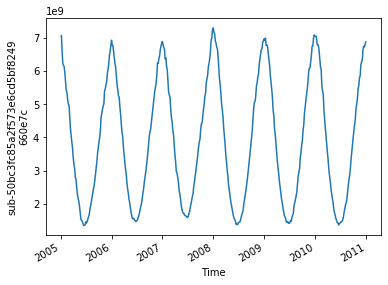

In [42]:
sw_test.sum(dim=['XC', 'YC', 'Z']).plot()

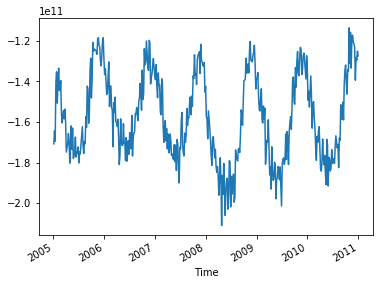

In [43]:
(budget_surf_th.surface_flux_conv_TH + sw_test).sum(dim=['XC', 'YC', 'Z']).plot()

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


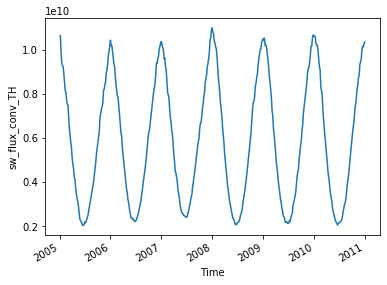

In [39]:
budget_surf_th.sw_flux_conv_TH.sum(dim=['XC', 'YC', 'Zl']).plot()

In [19]:
budget_surf_slt = xr.merge([surf_flux_slt.rename('surface_flux_conv_SLT'),
                            lin_fs_correction_slt.rename('lin_fs_correction_SLT')])
budget_surf_slt

<xarray.Dataset>
Dimensions:                (XC: 2160, YC: 320, time: 438)
Coordinates:
  * XC                     (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                     (YC) float32 -77.87497 -77.7083 ... -24.7083
  * time                   (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    surface_flux_conv_SLT  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    lin_fs_correction_SLT  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>

In [13]:
t_s = xr.merge([dsr.THETA, dsr.SALT])
t_s

<xarray.Dataset>
Dimensions:  (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    THETA    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    SALT     (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>

## Saving Data

In [14]:
gcfs_auth = gcsfs.GCSFileSystem(project='pangeo-181919', token='browser')
token = gcfs_auth.tokens[('pangeo-181919', 'full_control')]
gcfs_w_token = gcsfs.GCSFileSystem(project='pangeo-181919', token=token)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=586241054156-9kst7ltfj66svc342pcn43vp6ta3idin.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&state=xmvxcWYLFQHOMkk2Kf7MSnHLMMnDaz&prompt=consent&access_type=offline


Enter the authorization code:  4/uQE5E4yVH2NmfcqoZ0bHX3kHn4TarCTLNw0Pmwtiqq7nvTsXn-WOVaU


In [ ]:
gcfs_w_token.clear_instance_cache()

In [21]:
gcsmap_slt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_slt.zarr') #creating a map of path file will be stored in
gcsmap_slt

In [23]:
#saving salt budget
budget_slt.to_zarr(gcsmap_slt, mode='w') #writing the dataset into a file with the specified path

In [24]:
gcsmap_th = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_th.zarr')
gcsmap_th

In [25]:
#saving heat budget
budget_th.to_zarr(gcsmap_th, mode='w')

In [50]:
gcsmap_surf_th = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_surf_th.zarr')
gcsmap_surf_th

In [51]:
#saving heat surface terms
budget_surf_th.to_zarr(gcsmap_surf_th, mode='w')

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1299, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 1028, in _reconnect
    await self._close()
  File "/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/client.py", line 129

In [29]:
gcsmap_surf_slt = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_surf_slt.zarr')
gcsmap_surf_slt

In [30]:
#saving salt surface terms
budget_surf_slt.to_zarr(gcsmap_surf_slt, mode='w')

In [47]:
gcsmap_surf_th_test = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/budget_surf_th_test.zarr')
gcsmap_surf_th_test

In [48]:
#saving heat surface terms w/ sw defined from Ryan's function
budget_surf_th_test.to_zarr(gcsmap_surf_th_test, mode='w')

In [15]:
gcsmap_t_s = gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/t_s.zarr')
gcsmap_t_s

In [16]:
#saving heat/salt data for WMT budget using xhistogram
t_s.to_zarr(gcsmap_t_s, mode='w')

## Rechunking data variables to be uniform chunk sizes

Note to self: 
- save the surface terms in a separate ds (surf, lin_fs_corr, and sw)
- rechunk the whole ds to make the chunk sizes uniform for zarr to be happy
- raise an issue about the workers dying. To reproduce it maybe try adaptive scaling to see if you see the same issues again, bc rn it seems to be working.

In [ ]:
#rechunking to make all variables' chunks uniform shapes so that zarr can be happy
budget_slt = budget_slt.chunk({'XC': -1, 'YC': -1, 'Z': -1})
budget_slt

In [ ]:
budget_th = budget_th.chunk({'XC': -1, 'YC': -1, 'Z': -1})
budget_th

In [ ]:
#store as dif ds, and wehn analyzing merge them
surface_to_3d(surf_flux_th)

## WG entire column

In [ ]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [ ]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

**If this is discretized, since we're on individual grid-pt level, I don't need to define a lower range z for interior?**

In [ ]:
budget_slt_wg = budget_slt.isel(**lat_range_lower, **lon_range_lower)

In [ ]:
budget_th_wg = budget_th.isel(**lat_range_lower, **lon_range_lower)
budget_th_wg

In [ ]:
budget_th_wg['total_tendency_TH'] = (budget_th_wg.conv_horiz_adv_flux_TH + budget_th_wg.conv_horiz_diff_flux_TH 
                                     + budget_th_wg.surface_flux_conv_TH + budget_th_wg.lin_fs_correction_TH)

In [ ]:
budget_slt_wg['total_tendency_SLT'] = (budget_slt_wg.conv_horiz_adv_flux_SLT + 
                                       budget_slt_wg.conv_horiz_diff_flux_SLT + 
                                       budget_slt_wg.surface_flux_conv_SLT + 
                                       budget_slt_wg.lin_fs_correction_SLT)

In [ ]:
budget_th_wg

In [ ]:
import dask
dask.compute?

In [ ]:
tmp = dask.compute(budget_th_wg.conv_horiz_diff_flux_TH.sum(dim=['XC', 'YC', 'Z']), retries=5)

In [ ]:
rhs_th = budget_th_wg.total_tendency_TH.sum(dim=['XC', 'YC', 'Z']).load()

In [ ]:
lhs_th = budget_th_wg.total_tendency_TH_truth.sum(dim=['XC', 'YC', 'Z']).load()

In [ ]:
plt.figure(figsize=(12,6))
rhs_th.plot(label='rhs')
lhs_th.plot(label='lhs')
plt.legend();

In [ ]:
budget_slt_wg

In [ ]:
rhs_slt = budget_slt_wg.total_tendency_SLT.sum(dim=['XC', 'YC', 'Z']).load()
lhs_slt = budget_slt_wg.total_tendency_SLT_truth.sum(dim=['XC', 'YC', 'Z']).load()

In [ ]:
plt.figure(figsize=(12,6))
rhs_slt.plot(label='rhs')
lhs_slt.plot(label='lhs')
plt.legend();

## WG Interior

In [ ]:
rhs_th_lower = budget_th_wg.total_tendency_TH.isel(**lower_cell_range_z).sum(dim=['XC', 'YC', 'Z']).load()
lhs_th_lower = budget_th_wg.total_tendency_TH_truth.isel(**lower_cell_range_z).sum(dim=['XC', 'YC', 'Z']).load()

In [ ]:
plt.figure(figsize=(12,6))
rhs_th_lower.plot(label='rhs')
lhs_th_lower.plot(label='lhs')
plt.legend();

In [ ]:
rhs_slt_lower = budget_slt_wg.isel(**lower_cell_range_z).total_tendency_SLT.sum(dim=['XC', 'YC', 'Z']).load()
lhs_slt_lower = budget_slt_wg.isel(**lower_cell_range_z).total_tendency_SLT_truth.sum(dim=
                                                                                      ['XC', 'YC', 'Z']).load()

In [ ]:
plt.figure(figsize=(12,6))
rhs_slt_lower.plot(label='rhs')
lhs_slt_lower.plot(label='lhs')
plt.legend();